# Optical Pumping

This little script tests the optical pumping from the optical Bloch equations
and rate equations.  It reproduces Fig. 5 of Ungar, P. J., Weiss, D. S., Riis,
E., & Chu, S., "Optical molasses and multilevel atoms: theory", *Journal of
the Optical Society of America B*, **6** (11), 2058 (1989).
http://doi.org/10.1364/JOSAB.6.002058

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.common import spherical2cart

transform = False # Change the variable to transform OBEs into re/im components.

### Define the problem

As always, we first define the laserBeams, Hamiltonian, and magnetic field.  Here, we are interested in a $F=2\rightarrow F'=3$ transition under linearly polarized light.  We make three combinations of laser beams, each with linear polarization along a different axis.  Note that agreement between rate equations and the optical Bloch equations will only occur with the rate equations in the case of a single laser beam.  This is because the rate equations assume that thelasers are incoherent (their electric fields do not add to give twice the
amplitude) whereas the optical Bloch equations do.  Specifically, two coherent beams doubles the electric field which quadrupoles the intensity, so to compare the rate equations, we have to mulitply by $4$.  We do that for $\pi_y$ and $\pi_z$ polarizations.  For the $\pi_x$ beams, we separate it into two beams.

Compared to Ungar *et. al.*, the saturation parameter is defined differently.  There's is defined using $\gamma = \Gamma/2 - i\Delta$, which is different from ours.  Namely, the ratio between the two is $(\Gamma^2+\Delta^2)/\Gamma^2 = 1+\Delta^2/\Gamma^2$. 

Finally, one can put the detuning on the laser or put the detuning on the Hamiltonian (or some combination of the two).  The latter appears to be faster.

In [2]:
gamma = 1 # Also can demonstrate how to change gamma from 1

# First the laser beams:
laserBeams = {}
laserBeams['$\\pi_z$']= pylcp.laserBeams([
    {'kvec': np.array([1., 0., 0.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'cartesian', 'delta':-2.73*gamma, 's':4*0.16*(1+2.73**2)}
    ])
laserBeams['$\\pi_y$']= pylcp.laserBeams([
    {'kvec': np.array([0., 0., 1.]), 'pol':np.array([0., 1., 0.]),
     'pol_coord':'cartesian', 'delta':-2.73*gamma, 's':4*0.16*(1+2.73**2)}
    ])
laserBeams['$\\pi_x$']= pylcp.laserBeams([
    {'kvec': np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':-2.73*gamma, 's':0.16*(1+2.73**2)},
    {'kvec': np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':-2.73*gamma, 's':0.16*(1+2.73**2)}
    ])

# Then the magnetic field:
magField = lambda R: np.zeros(R.shape)

# Hamiltonian for F=2->F=3
H_g, muq_g = pylcp.hamiltonians.singleF(F=2, gF=1, muB=1)
H_e, mue_q = pylcp.hamiltonians.singleF(F=3, gF=1, muB=1)
d_q = pylcp.hamiltonians.dqij_two_bare_hyperfine(2, 3)
hamiltonian = pylcp.hamiltonian()
hamiltonian.add_H_0_block('g', H_g)
hamiltonian.add_H_0_block('e', H_e-0.*np.eye(H_e.shape[0]))
hamiltonian.add_d_q_block('g', 'e', d_q, gamma=gamma)

hamiltonian.print_structure()

[[(<g|H_0|g> 5x5) (<g|d_q|e> 5x7)]
 [(<e|d_q|g> 7x5) (<e|H_0|e> 7x7)]]


### Evolve the density/populations
Using both the `rateeq` and `obe`, we will calculate the population transfer.

In [3]:
obe = {}
rateeq = {}
rateeq['$\\pi_z$'] = pylcp.rateeq(laserBeams['$\\pi_z$'], magField,
                                  hamiltonian)
obe['$\\pi_z$'] = pylcp.obe(laserBeams['$\\pi_z$'], magField, hamiltonian,
                            transform_into_re_im=transform)

# Run the rate equations:
N0 = np.zeros((rateeq['$\\pi_z$'].hamiltonian.n,))
N0[0] = 1
rateeq['$\\pi_z$'].set_initial_pop(N0)
rateeq['$\\pi_z$'].evolve_populations([0, 600/gamma],
                                      max_step=1/gamma)

# Run the OBEs:
rho0 = np.zeros((obe['$\\pi_z$'].hamiltonian.n**2,))
rho0[0] = 1.
obe['$\\pi_z$'].set_initial_rho(np.real(rho0))
obe['$\\pi_z$'].evolve_density(t_span=[0, 600/gamma],
                               progress_bar=True)

# Calculate the equilibrium populations:
Neq = rateeq['$\\pi_z$'].equilibrium_populations(np.array([0., 0., 0.]),
                                                 np.array([0., 0., 0.]), 0.)

Completed in 1.76 s.                                                  


Plot up the results:

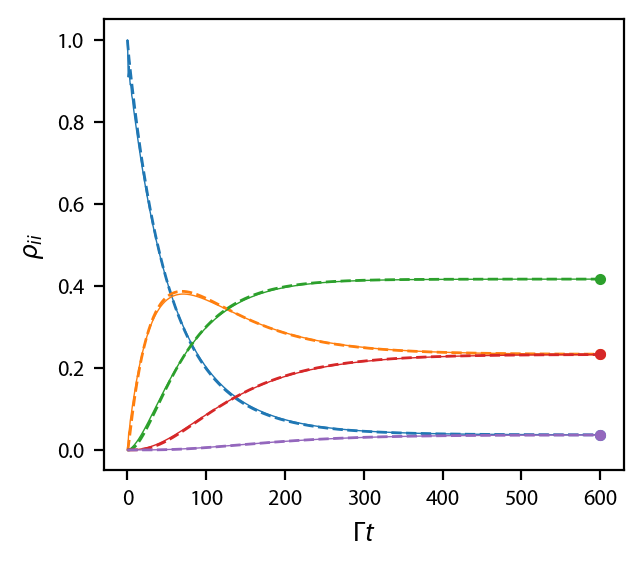

In [4]:
fig, ax = plt.subplots(1, 1)
for jj in range(5):
    ax.plot(gamma*rateeq['$\\pi_z$'].sol.t,
            rateeq['$\\pi_z$'].sol.y[jj, :], '--',
            color='C{0:d}'.format(jj),
            linewidth=1.0)
    ax.plot(gamma*obe['$\\pi_z$'].sol.t, np.abs(obe['$\\pi_z$'].sol.rho[jj, jj]), '-',
            color='C{0:d}'.format(jj),
            linewidth=0.5)
    ax.plot(gamma*obe['$\\pi_z$'].sol.t[-1], Neq[jj], '.', color='C{0:d}'.format(jj),
            linewidth=0.5)

ax.set_xlabel('$\\Gamma t$')
ax.set_ylabel('$\\rho_{ii}$');

### Check rotations

Next, we want to check that our rotations are working properly, so we will
run the same calculation for the $\hat{z}$ going beam with $\pi_y$ polarization.  But
before we even bother working with the OBE, we need to create the initial
state first, which involves rotating our state.

In [5]:
mug = spherical2cart(muq_g)
S = -mug

# What are the eigenstates of 'y'?
E, U = np.linalg.eig(S[1])

# Let's now define a rotation matrix that rotates us into the m_F basis alogn y:
inds = np.argsort(E)
E = E[inds]
U = U[:, inds]
Uinv = np.linalg.inv(U)

# In a positive magnetic field with g_F>0, I want the lowest eigenvalue. That
# corresponds to the -m_F state.
psi = U[:, 0]

# Now take that state and make the initial density matrix:
rho0 = np.zeros((hamiltonian.n, hamiltonian.n), dtype='complex128')
for ii in range(hamiltonian.ns[0]):
    for jj in range(hamiltonian.ns[0]):
        rho0[ii, jj] = psi[ii]*np.conjugate(psi[jj])

#Print out the density matrix (in z-basis), and the rotated density matrix (in y-basis):
#print(rho0[:5,:5])
#print(Uinv@rho0[:5,:5]@U)

# Evolve:
obe['$\\pi_y$'] = pylcp.obe(laserBeams['$\\pi_y$'], magField, hamiltonian,
                            transform_into_re_im=transform)
obe['$\\pi_y$'].set_initial_rho(rho0.reshape(hamiltonian.n**2,))
obe['$\\pi_y$'].evolve_density(t_span=[0, 600],
                               progress_bar=True)

# Now rotate the denisty matrix back to be along $y$:
for jj in range(obe['$\\pi_y$'].sol.t.size):
    obe['$\\pi_y$'].sol.rho[:5, :5, jj] = Uinv@obe['$\\pi_y$'].sol.rho[:5, :5, jj]@U

Completed in 1.71 s.                                               


Now plot it up:

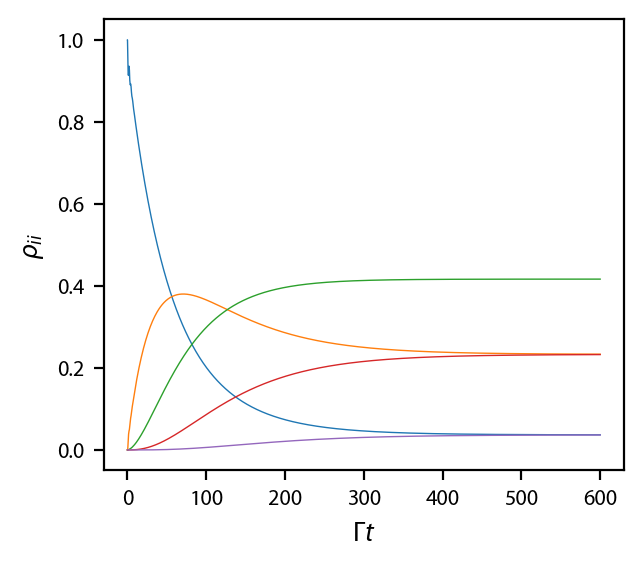

In [6]:
fig, ax = plt.subplots(1, 1)
for jj in range(5):
    ax.plot(obe['$\\pi_y$'].sol.t,
            np.abs(obe['$\\pi_y$'].sol.rho[jj, jj]), '-',
            color='C{0:d}'.format(jj),
            linewidth=0.5)
ax.set_xlabel('$\\Gamma t$')
ax.set_ylabel('$\\rho_{ii}$');

Now, let's do the same thing for $\pi_x$, except this time we have two laser
beams, with 1/4 of the intensity:

In [7]:
# What are the eigenstates of 'y'?
E, U = np.linalg.eig(S[0])

inds = np.argsort(E)
E = E[inds]
U = U[:, inds]
Uinv = np.linalg.inv(U)

# In a positive magnetic field with g_F>0, I want the lowest eigenvalue. That
# corresponds to the -m_F state.
psi = U[:, 0]

rho0 = np.zeros((hamiltonian.n, hamiltonian.n), dtype='complex128')
for ii in range(hamiltonian.ns[0]):
    for jj in range(hamiltonian.ns[0]):
        rho0[ii, jj] = psi[ii]*np.conjugate(psi[jj])

obe['$\\pi_x$'] = pylcp.obe(laserBeams['$\\pi_x$'], magField, hamiltonian,
                            transform_into_re_im=transform)
obe['$\\pi_x$'].set_initial_rho(rho0.reshape(hamiltonian.n**2,))
obe['$\\pi_x$'].evolve_density(t_span=[0, 600],
                               progress_bar=True)

for jj in range(obe['$\\pi_x$'].sol.t.size):
    obe['$\\pi_x$'].sol.rho[:5, :5, jj] = Uinv@obe['$\\pi_x$'].sol.rho[:5, :5, jj]@U

Completed in 1.97 s.                                               


Plot this up too:

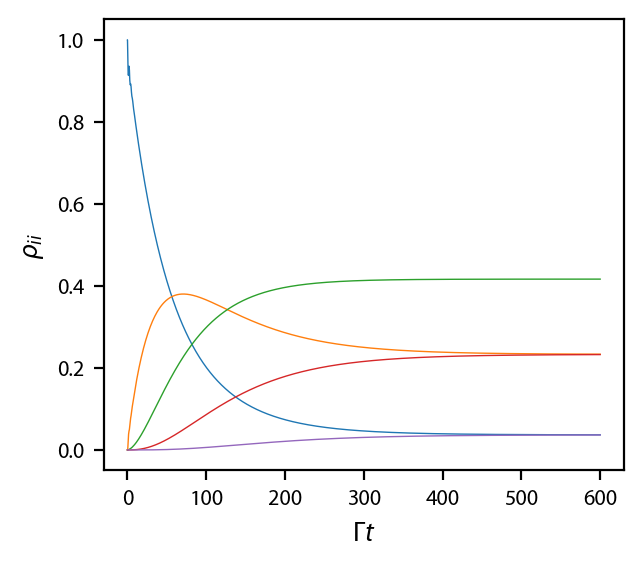

In [8]:
fig, ax = plt.subplots(1, 1)
for jj in range(5):
    ax.plot(obe['$\\pi_x$'].sol.t,
            np.abs(obe['$\\pi_x$'].sol.rho[jj, jj]), '-',
            color='C{0:d}'.format(jj),
            linewidth=0.5)
ax.set_xlabel('$\\Gamma t$')
ax.set_ylabel('$\\rho_{ii}$');